In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.src.legacy.saving import legacy_h5_format

In [3]:
import os
import random
import shutil
  
# Paths
src_folder = r"D:\Automatic_Face_Labelling\Dataset\UTKFace"  # where your original UTKFace images are
labeled_folder = r"D:\Automatic_Face_Labelling\Dataset\labeled"
unlabeled_folder = r"D:\Automatic_Face_Labelling\Dataset\unlabeled"

os.makedirs(labeled_folder, exist_ok=True)
os.makedirs(unlabeled_folder, exist_ok=True) 

# Percentage of dataset to make "unlabeled"
UNLABELED_SPLIT = 0.5  # 50% unlabeled

# Get all images
images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.png'))]
random.shuffle(images)

# Split
split_index = int(len(images) * UNLABELED_SPLIT)
unlabeled_imgs = images[:split_index]
labeled_imgs = images[split_index:]

# Move files
for img in labeled_imgs:
    shutil.copy(os.path.join(src_folder, img), os.path.join(labeled_folder, img))

for img in unlabeled_imgs:
    shutil.copy(os.path.join(src_folder, img), os.path.join(unlabeled_folder, img))

print(f"Labeled: {len(labeled_imgs)}, Unlabeled: {len(unlabeled_imgs)}")


Labeled: 11854, Unlabeled: 11854


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# ====== 1. Labeled images ======
labeled_dir =  r"D:\Automatic_Face_Labelling\Dataset\labeled"
unlabeled_dir = r"D:\Automatic_Face_Labelling\Dataset\unlabeled"


# Function to load images from a flat folder (no subfolders)
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    labels = []  # optional: only for labeled data

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = image.load_img(file_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)

            # If the folder name is the label
            # labels.append(folder_label)  # You can handle real labels here

    return np.array(images)

# Load labeled data
X_labeled = load_images_from_folder(labeled_dir, target_size=(64, 64))
# Example: create dummy labels for now
y_labeled = np.zeros(len(X_labeled))  # replace with real labels later

# Load unlabeled data
X_unlabeled = load_images_from_folder(unlabeled_dir, target_size=(64, 64))

print("Labeled images shape:", X_labeled.shape)
print("Unlabeled images shape:", X_unlabeled.shape)


Labeled images shape: (23702, 64, 64, 3)
Unlabeled images shape: (23700, 64, 64, 3)


Final shape: (23700, 48, 48, 3) Min: 0.0 Max: 1.0


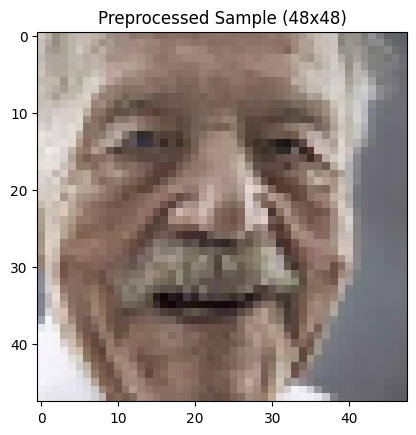

In [6]:
def preprocess_age_gender_image(img):
    # Ensure correct size for your model
    img_resized = tf.image.resize(img, (48, 48))
    # Already scaled to [0,1] in your loader
    return img_resized.numpy()

# Apply preprocessing
X_unlabeled_resized = np.array([preprocess_age_gender_image(img) for img in X_unlabeled])
X_labeled_resized = np.array([preprocess_age_gender_image(img) for img in X_labeled])

print("Final shape:", X_unlabeled_resized.shape, 
      "Min:", X_unlabeled_resized.min(), 
      "Max:", X_unlabeled_resized.max())

# Show a sample
import matplotlib.pyplot as plt
sample = X_unlabeled_resized[0]
plt.imshow(sample)
plt.title("Preprocessed Sample (48x48)")
plt.show()


In [7]:
import cv2
import numpy as np

def preprocess_ethnicity_image(img):
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    return img
# Example: preprocess whole batch
X_unlabeled_ethnicity = np.array([preprocess_ethnicity_image(img) for img in X_unlabeled])


In [8]:
import cv2
import numpy as np

def preprocess_for_emotion(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # grayscale
    img = cv2.resize(img, (48,48))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # channel dimension add
    return img

    
X_unlabeled_emotion = np.array([preprocess_for_emotion(img) for img in X_unlabeled])

In [12]:
from tensorflow.keras.models import load_model
import numpy as np

# Load your pre-trained models
age_gender_model = load_model(r"D:\Automatic_Face_Labelling\models\Age_Sex_Detection.h5",compile=False)
ethnicity_model = load_model(r"D:\Automatic_Face_Labelling\models\nationality_model.h5")
emotion_model = load_model(r"D:\Automatic_Face_Labelling\models\emotion_model.h5")

# Predict with each model
gender_preds, age_preds = age_gender_model.predict(X_unlabeled_resized)
ethnicity_preds = ethnicity_model.predict(X_unlabeled_ethnicity)
emotion_preds = emotion_model.predict(X_unlabeled_emotion)

# Convert predictions to class labels
gender_probs = gender_preds.ravel()                    # sigmoid outputs → confidence for "male"
gender_pseudo = (gender_probs > 0.5).astype(int)  # threshold at 0.5

age_nums = age_preds.ravel()                        # raw regression ages
age_pseudo = np.clip(np.round(age_nums), 0, 100).astype(int)
ethnicity_pseudo = np.argmax(ethnicity_preds, axis=1)
emotion_pseudo = np.argmax(emotion_preds, axis=1)

print("Pseudo labels generated.")


741/741 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step
741/741 ━━━━━━━━━━━━━━━━━━━━ 128s 172ms/step
Pseudo labels generated.


In [13]:
for i in range(10):
    print(f"Image {i}: Age={age_pseudo[i]} (raw: {age_nums[i]:.2f}), "
          f"Gender={gender_pseudo[i]} (conf: {gender_probs[i]:.2f})")

Image 0: Age=71 (raw: 71.00), Gender=0 (conf: 0.06)
Image 1: Age=92 (raw: 92.24), Gender=0 (conf: 0.18)
Image 2: Age=68 (raw: 67.56), Gender=0 (conf: 0.17)
Image 3: Age=89 (raw: 88.80), Gender=1 (conf: 0.71)
Image 4: Age=100 (raw: 104.82), Gender=1 (conf: 0.69)
Image 5: Age=83 (raw: 83.19), Gender=1 (conf: 0.55)
Image 6: Age=94 (raw: 94.40), Gender=1 (conf: 0.83)
Image 7: Age=100 (raw: 102.20), Gender=1 (conf: 0.78)
Image 8: Age=63 (raw: 63.09), Gender=1 (conf: 0.76)
Image 9: Age=77 (raw: 76.83), Gender=0 (conf: 0.04)


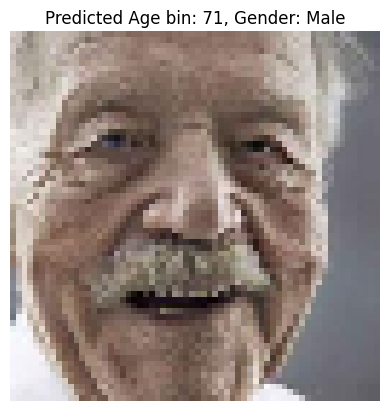

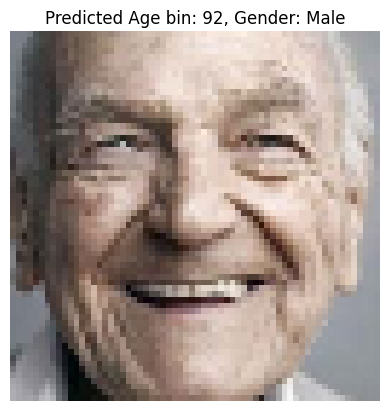

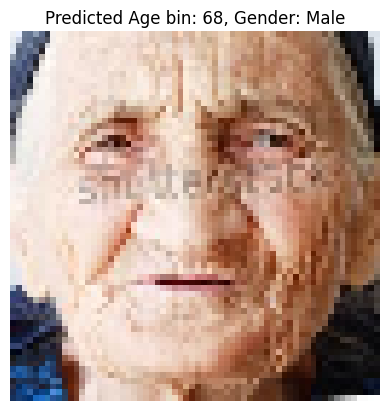

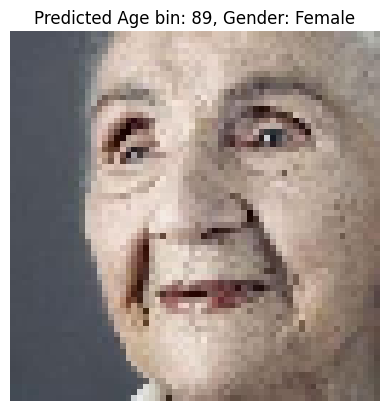

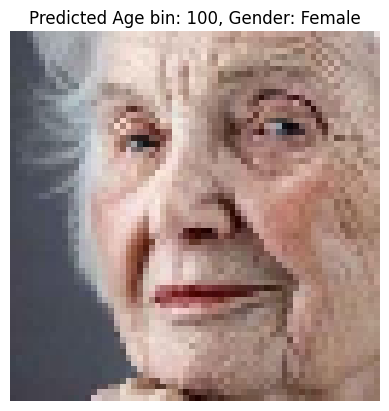

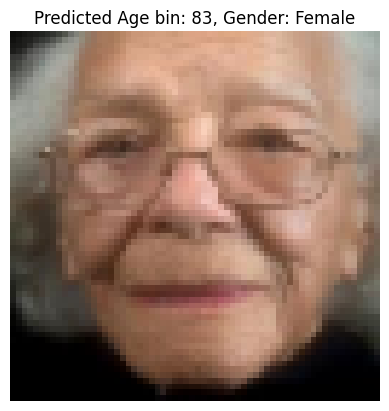

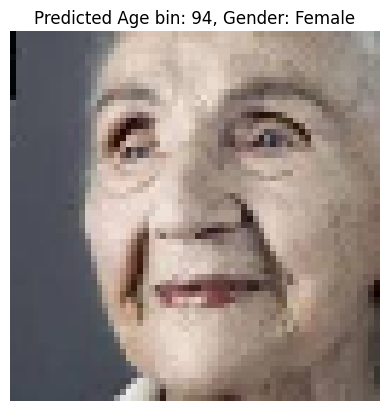

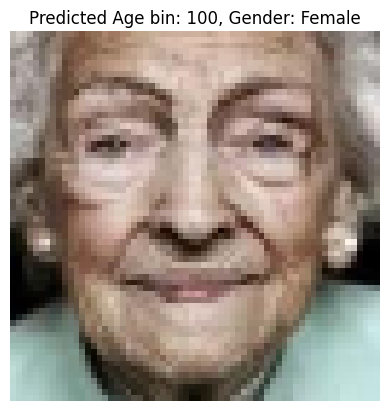

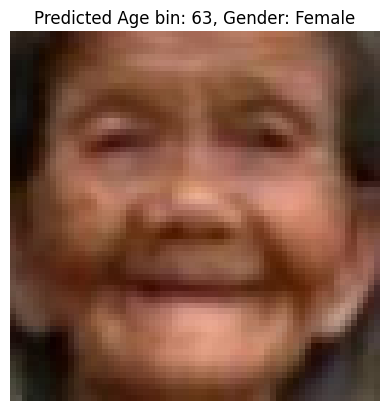

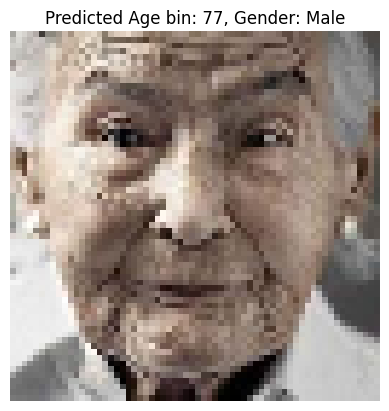

In [14]:
import matplotlib.pyplot as plt

# Assuming you have X_unlabeled_processed images in shape (N, H, W, C)
# And predicted age_classes and gender_classes from before

def display_images_with_pseudo_labels(images, age_preds, gender_preds, num=10):
    for i in range(num):
        img = images[i]
        age = age_preds[i]
        gender = gender_preds[i]

        # If grayscale (1 channel), reshape to 2D for display
        if img.shape[-1] == 1:
            img = img.reshape(img.shape[0], img.shape[1])

        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.title(f"Predicted Age bin: {age}, Gender: {'Male' if gender==0 else 'Female'}")
        plt.axis('off')
        plt.show()

display_images_with_pseudo_labels(X_unlabeled, age_pseudo, gender_pseudo, num=10)


In [15]:
def extract_labels_from_filenames(folder):
    ages, genders = [], []
    images = []
    
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            try:
                age, gender, *_ = filename.split("_")
                ages.append(int(age))
                genders.append(int(gender))
            except:
                continue
    return np.column_stack([ages, genders])  # shape: (N, 2)

# For your labeled dataset
y_labeled = extract_labels_from_filenames(labeled_dir)
print(y_labeled.shape)   # (num_labeled, 2)









(23702, 2)


In [16]:
y_pseudo = np.column_stack([age_pseudo, gender_pseudo])     # from your predictions
# y_labeled should be [[age, gender], ...] for your labeled part
X_combined = np.concatenate([X_labeled_resized, X_unlabeled_resized], axis=0)
y_combined = np.concatenate([y_labeled,y_pseudo],axis=0)
y_combined.shape

(47402, 2)

In [24]:
y_age = y_combined[:, 0]
y_gender = y_combined[:, 1]

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    X_combined, y_age, y_gender, test_size=0.2, random_state=42
)


In [26]:
# Split labels into gender and age
  # age column
age_gender_model = load_model(r"D:\Automatic_Face_Labelling\models\Age_Sex_Detection.h5",compile=False)
from tensorflow.keras.optimizers import Adam

# Compile model
from tensorflow.keras.optimizers import Adam

# Recompile with correct losses
age_gender_model.compile(
    optimizer="adam",
    loss={
        "age_out": "mse",                 # regression for age
        "sex_out": "binary_crossentropy"  # classification for gender
    },
    metrics={
        "age_out": "mae",
        "sex_out": "accuracy"
    }
)

# Retrain
history = age_gender_model.fit(
    X_train,
    {
        "age_out": y_age_train,
        "sex_out": y_gender_train
    },
    validation_data=(
        X_test,
        {
            "age_out": y_age_test,
            "sex_out": y_gender_test
        }
    ),
    epochs=10,
    batch_size=32
)

# Evaluate



Epoch 1/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 77s 61ms/step - age_out_loss: 73.7010 - age_out_mae: 6.0110 - loss: 74.7197 - sex_out_accuracy: 0.8951 - sex_out_loss: 0.2514 - val_age_out_loss: 151.1267 - val_age_out_mae: 10.0446 - val_loss: 152.3954 - val_sex_out_accuracy: 0.9076 - val_sex_out_loss: 0.2131
Epoch 2/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - age_out_loss: 82.2665 - age_out_mae: 6.3644 - loss: 83.5188 - sex_out_accuracy: 0.8724 - sex_out_loss: 0.2984 - val_age_out_loss: 42.6456 - val_age_out_mae: 4.2830 - val_loss: 44.0092 - val_sex_out_accuracy: 0.9028 - val_sex_out_loss: 0.2256
Epoch 3/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 78s 66ms/step - age_out_loss: 70.1986 - age_out_mae: 5.9357 - loss: 71.5880 - sex_out_accuracy: 0.8809 - sex_out_loss: 0.2807 - val_age_out_loss: 39.6276 - val_age_out_mae: 4.1414 - val_loss: 41.0839 - val_sex_out_accuracy: 0.9150 - val_sex_out_loss: 0.2128
Epoch 4/10
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - age_out_loss: 68.2795 - age_out_mae: 5.

In [27]:
results = age_gender_model.evaluate(
    X_test,
    {
        "age_out": y_age_test,
        "sex_out": y_gender_test
    },
    verbose=1
)

print("\nTest Results:")
for name, value in zip(age_gender_model.metrics_names, results):
    print(f"{name}: {value:.4f}")


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - age_out_loss: 42.6409 - age_out_mae: 4.2466 - loss: 45.1141 - sex_out_accuracy: 0.8948 - sex_out_loss: 0.2486

Test Results:
loss: 46.1828
compile_metrics: 0.2474
sex_out_loss: 43.6967
age_out_loss: 4.2938


In [56]:
age_gender_model.save("age_gender_pseudolabel_final.h5")
